In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv
/kaggle/input/smoker-status-prediction-using-biosignals/test_dataset.csv
/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from xgboost import XGBClassifier
import pandas as pd

# Set XGBoost hyperparameters
n_estimators = 600
max_depth = 6

# Read the CSV files
df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")  # Read the first dataset
pg = pd.read_csv("/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv")  # Read the second dataset

# Combine the DataFrames
df = pd.concat([pg, df])  # Merge both datasets
df.head()  # Display the first few rows of the combined DataFrame

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,id
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,142,19.8,1,1.0,61,115,125,1,1,NaN
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,114,15.9,1,1.1,19,25,30,1,0,NaN
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,112,13.7,3,0.6,1090,1400,276,0,0,NaN
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,91,16.9,1,0.9,32,36,36,0,0,NaN
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,92,14.9,1,1.2,26,28,15,0,0,NaN


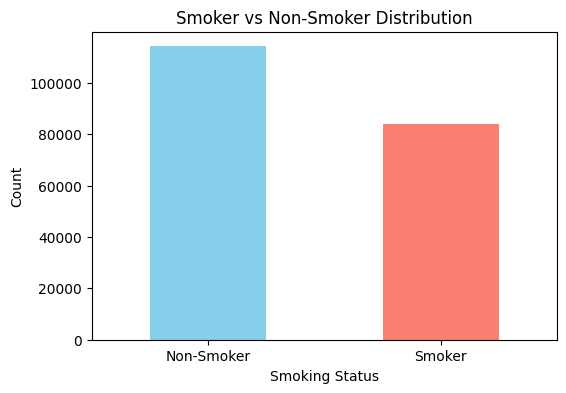

In [3]:
# EDA: Class Distribution  
import matplotlib.pyplot as plt  
plt.figure(figsize=(6, 4))  
df['smoking'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])  
plt.title('Smoker vs Non-Smoker Distribution')  
plt.xlabel('Smoking Status')  
plt.ylabel('Count')  
plt.xticks(ticks=[0, 1], labels=['Non-Smoker', 'Smoker'], rotation=0)  
plt.show()  

In [4]:
# Remove the 'id' column from the DataFrame
df.drop(columns=['id'], inplace=True)

# Calculate BMI and add it as a new column in the DataFrame
df['bmi'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2

# Store the feature names in a list, excluding the last but one column
features = list(df.columns)
features.pop(-2)  # Exclude the second-to-last column (presumably the target variable)

'smoking'

In [6]:
# Split the dataset into training and validation sets (80-20 split)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Reset the index for both training and validation sets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# Extract the target variables from the training and validation sets
y_train = df_train.smoking.values
y_val = df_val.smoking.values

# Remove the 'smoking' column from both training and validation sets
del df_train['smoking']
del df_val['smoking']

In [8]:
# Initialize an XGBoost Classifier with specified parameters
xgb_model = XGBClassifier(tree_method='hist',
                          n_estimators=600,
                          max_depth=6,
                          learning_rate=0.1,
                          colsample_bytree=0.5)

# Fit the XGBoost model on the training data
xgb_model.fit(df_train, y_train)

# Predict probabilities and actual classes on the validation set
y_pred_prob = xgb_model.predict_proba(df_val)[:, 1]  # Predict probabilities for positive class
y_pred = xgb_model.predict(df_val)  # Predict classes

# Evaluate model performance using ROC AUC and accuracy
roc = metrics.roc_auc_score(y_val, y_pred_prob)  # Compute ROC AUC score
acc = metrics.accuracy_score(y_val, y_pred)  # Compute accuracy score

# Output the ROC AUC and accuracy scores
roc, acc

(0.8736238272666649, 0.78954802259887)

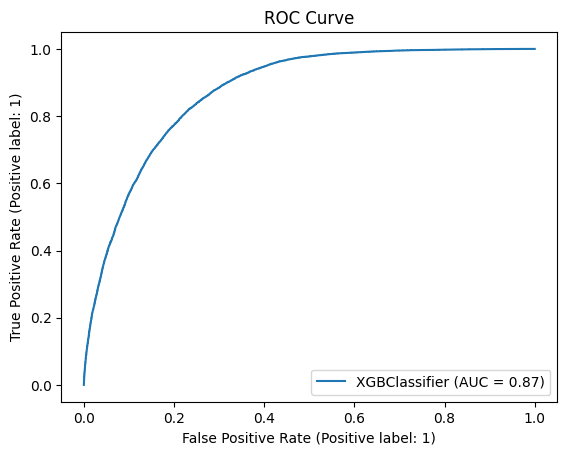

In [10]:
# ROC Curve  
from sklearn.metrics import RocCurveDisplay  
RocCurveDisplay.from_estimator(xgb_model, df_val, y_val)  
plt.title('ROC Curve')  
plt.show()  

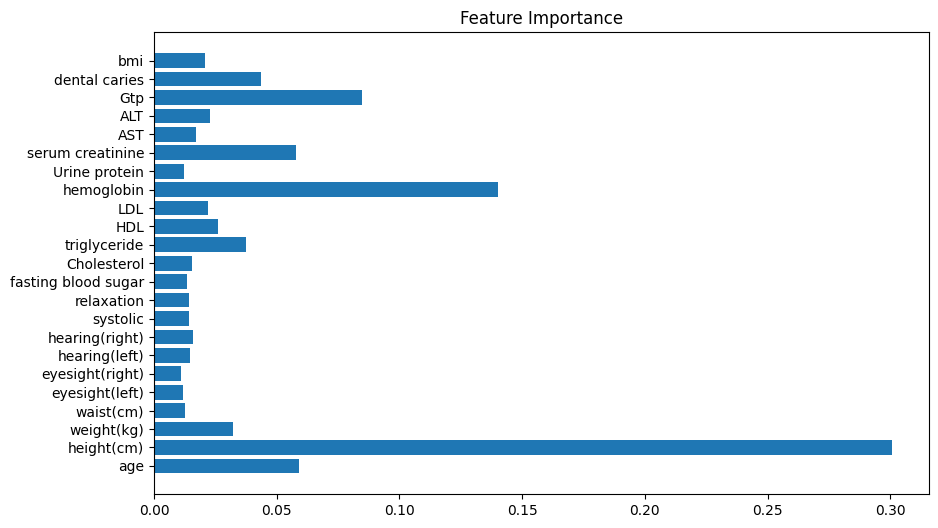

In [11]:
# Feature Importance  
plt.figure(figsize=(10, 6))  
plt.barh(features, xgb_model.feature_importances_)  
plt.title('Feature Importance')  
plt.show() 

In [12]:
# Read the sample submission and test dataset for prediction
submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

# Drop the 'id' column from the test data
test_df.drop(columns=['id'], inplace=True)

# Display the first few rows of the test dataset
test_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,40,165,70,84.0,1.2,1.2,1,1,130,89,...,186,49,115,14.2,1,0.9,19,25,32,0
1,80,160,60,93.0,1.0,1.0,2,2,144,72,...,158,35,104,13.0,1,1.1,20,12,24,0
2,60,170,70,86.5,0.6,0.7,1,1,117,75,...,173,39,88,15.4,1,1.4,38,60,36,0
3,40,160,50,67.0,0.3,0.4,1,1,116,62,...,47,75,128,14.5,1,0.6,25,18,10,1
4,40,170,75,89.4,1.0,0.9,1,1,132,94,...,100,39,123,16.5,1,1.0,30,39,27,1


In [13]:
# Calculate BMI for the test dataset and add it as a new column
test_df['bmi'] = test_df['weight(kg)'] / (test_df['height(cm)'] / 100) ** 2

# Check the shape of the test dataset
test_df.shape  # Outputs the dimensions of the modified test dataset

(106171, 23)

In [14]:
# Predict probabilities for the test dataset using the trained XGBoost model
y_test = xgb_model.predict_proba(test_df)[:, 1]

In [15]:
# Update the 'smoking' column in the submission DataFrame with predicted values
submission['smoking'] = y_test

# Save the submission file without index to a CSV
submission.to_csv('submission.csv', index=False)